# Benchmarking Analysis on Raster Embedding Search Algorithm

This notebook delves into **quantum embedding experiments** using the `dwave_networkx` library, conducting a benchmarking analysis of graph embedding algorithms across diverse graph topologies, including Chimera, Pegasus, and Zephyr.



In [120]:
import dwave_networkx as dnx
from minorminer.utils.raster_embedding import (raster_embedding_search,
                                               raster_breadth_subgraph_lower_bound,
                                               visualize_embeddings)
import matplotlib.pyplot as plt
import numpy as np
from time import perf_counter
import networkx as nx
import seaborn as sns
import pandas as pd
import json
import os
%matplotlib inline

### Visualize embeddings on hardware graph using the smallest possible tile size:
Th following script visualizes graph embeddings within various D-Wave topologies (chimera, pegasus, and zephyr) by coloring nodes and edges according to their embedding group. It generates and embeds source graphs into target graphs, ensuring all nodes are disjoint, and displays each embedding in topology-specific layouts. The visualizations illustrate the structure and connectivity of embedded nodes, showing how smaller graph structures map within each topology.

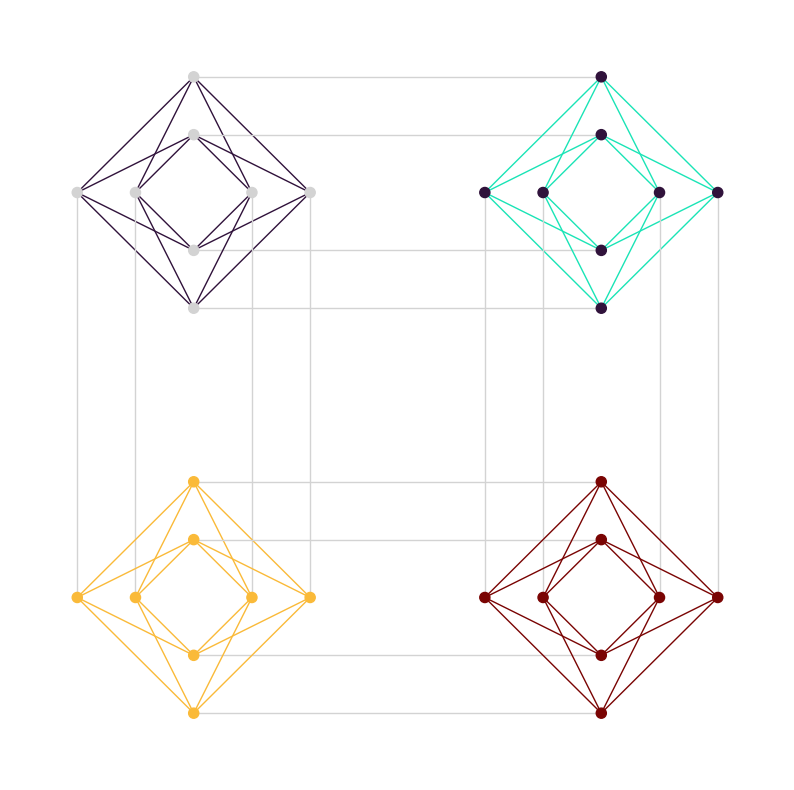

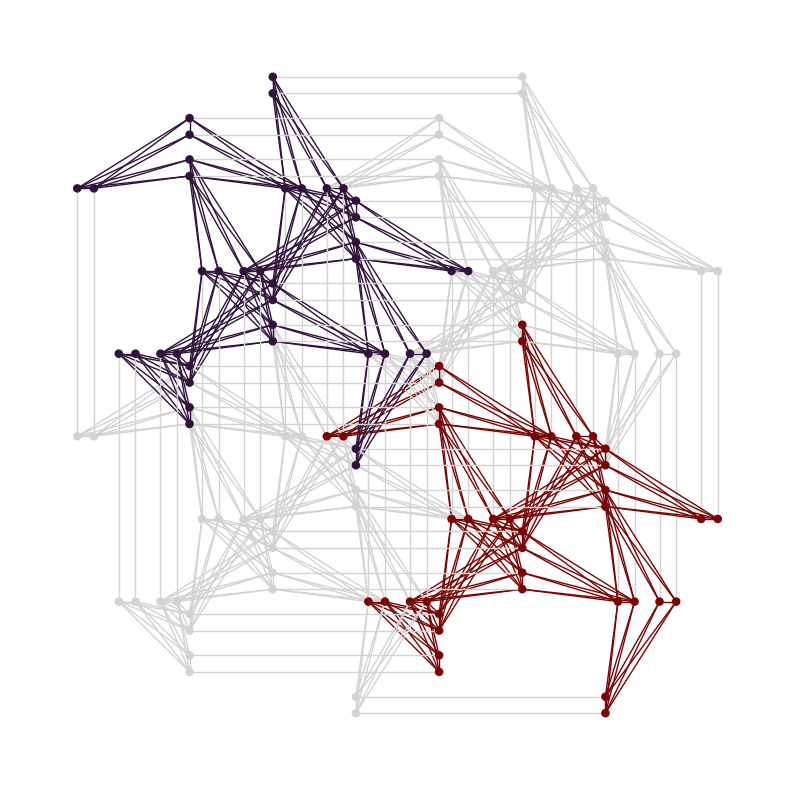

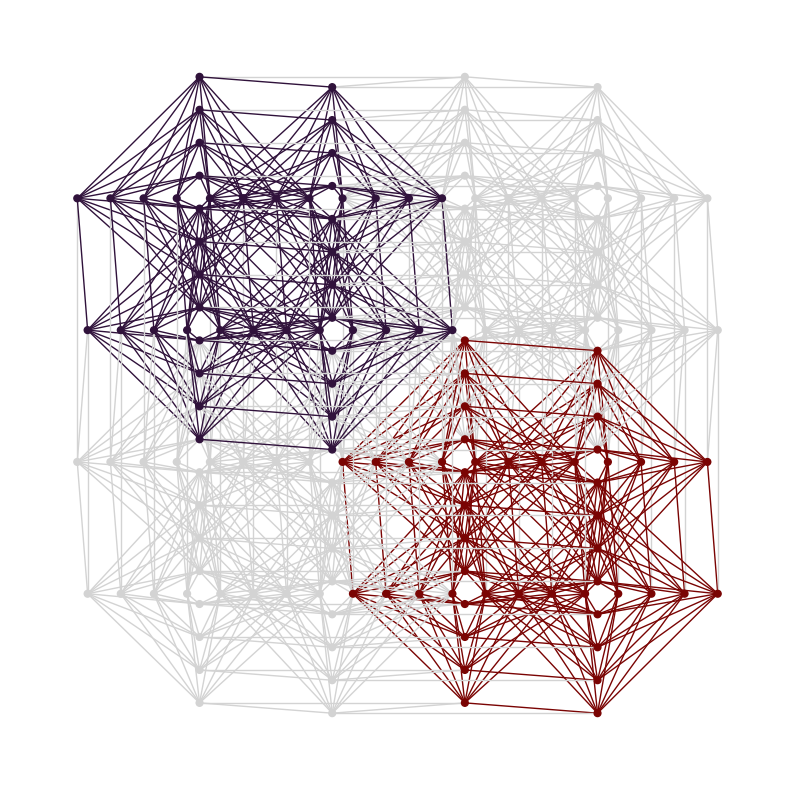

In [124]:
# Define the Graph Topologies, Tiles, and Generators
topologies = ['chimera', 'pegasus', 'zephyr']
smallest_tile = {'chimera': 1, 'pegasus': 2, 'zephyr': 1}
generators = {'chimera': dnx.chimera_graph, 'pegasus': dnx.pegasus_graph, 'zephyr': dnx.zephyr_graph}

# A check at minimal scale and visualization
for topology in topologies:
    min_raster_scale = smallest_tile[topology]
    S = generators[topology](min_raster_scale)
    T = generators[topology](min_raster_scale + 1)

    # Perform Embedding Search and Validation
    embs = raster_embedding_search(S, T, raster_breadth=min_raster_scale)
    assert all(set(emb.keys()) == set(S.nodes()) for emb in embs)
    assert all(set(emb.values()).issubset(set(T.nodes())) for emb in embs)
    value_list = [v for emb in embs for v in emb.values()]
    assert len(set(value_list)) == len(value_list)

    # Visualize Embeddings
    plt.figure(figsize=(10, 10))
    visualize_embeddings(H=T, embeddings=embs)
    plt.show()


### Process stored JSON data

Processes experimental data stored in a JSON file for 20 runs. Measures embedding times across three topologies with various source graph (**1-D ring**) sizes. Evaluates results across different target graph tile sizes. Calculates the mean and standard error of the mean (SEM) for each combination of tile size, topology, and raster breadth.

In [ ]:
# Load the JSON data from a file
with open('experiment_results/ring.json', 'r') as file:
    data = json.load(file)

# Initialize an empty list to store records
records = []

# Iterate over tile sizes (assuming 'L' corresponds to 'tile_size')
for tile_size in data:
    for topology in data[tile_size]:
        raster_breadth = data[tile_size][topology].get('Raster_Breadth', None)
        time_entries = data[tile_size][topology]['Time_1']
        for entry in time_entries:
            record = {
                'L': int(tile_size),
                'Topology': topology,
                'Raster_Breadth': raster_breadth,
                'Run': entry['Run'],
                'm_target': entry['m_target'],
                'Time_1': entry['Time_1'],
            }
            records.append(record)

# Convert the list of records into a DataFrame
df = pd.DataFrame(records)

# Filter for even Ls
df_even = df[df['L'] % 2 == 0]
# Replace 'null' strings with NaN
df_even['Time_1'] = df_even['Time_1'].replace('null', np.nan)

# Convert 'Time_1' to numeric, coercing errors to NaN
df_even['Time_1'] = pd.to_numeric(df_even['Time_1'], errors='coerce')

# Now fill NaN with 1
df_even['Time_1'] = df_even['Time_1'].fillna(1)

# Display the first few rows to verify
print(df_even.head())
print(df_even.dtypes)

df_aggregated = (
    df_even
    .groupby(['L', 'Topology', 'Raster_Breadth'], as_index=False)
    .agg(
        Time_1_mean=('Time_1', 'mean'),
        Time_1_sem=('Time_1', lambda x: np.std(x) / np.sqrt(len(x)))  # SEM
    )
)
print(df_aggregated.head())

### Time to Find One Embedding for Smallest Viable Raster Breadth (Defect-Free Graph)
Visualizes the mean time data across different L values and topologies from the aggregated dataset, with shaded confidence intervals to represent variability. Marks an upper threshold line representing the specific timeout. The x- and y-axes are set to logarithmic scales for better readability across a wide data range.

#### **Purpose: examine how embedding time changes for specific loop length and title size**

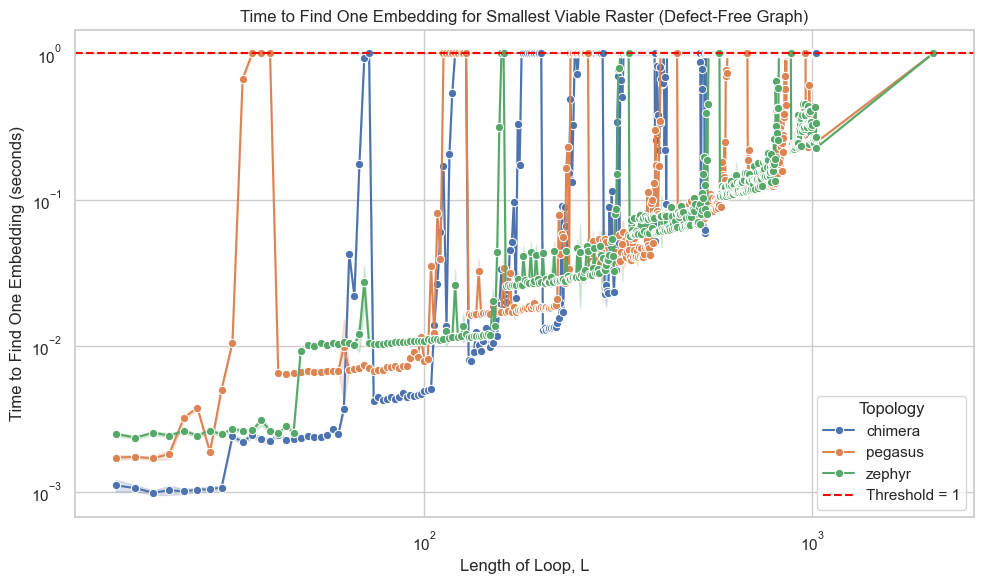

In [96]:
sns.set_theme(style="whitegrid")

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_aggregated,
    x='L',
    y='Time_1_mean',
    hue='Topology',
    marker='o',
    errorbar=None 
)
# Define the confidence interval multiplier for 95% CI
ci_multiplier = 1.96

# Retrieve the unique topologies
topologies = df_aggregated['Topology'].unique()

# Retrieve the color palette used by Seaborn for consistency
palette = sns.color_palette(n_colors=len(topologies))
color_dict = dict(zip(topologies, palette))

# Iterate over each topology to plot confidence intervals
for topology in topologies:
    # Subset the data for the current topology and sort by 'L'
    subset = df_aggregated[df_aggregated['Topology'] == topology].sort_values('L')
    
    # Calculate the confidence interval bounds
    ci_lower = subset['Time_1_mean'] - ci_multiplier * subset['Time_1_sem']
    ci_upper = subset['Time_1_mean'] + ci_multiplier * subset['Time_1_sem']
    
    # Plot the shaded confidence interval
    plt.fill_between(
        subset['L'],
        ci_lower,
        ci_upper,
        color=color_dict[topology],
        alpha=0.2  # Transparency for the shaded region
    )

# Define the upper_threshold
upper_threshold = 1
plt.axhline(
    upper_threshold, 
    color='red', 
    linestyle='--', 
    label=f'Threshold = {upper_threshold}'
)

# Set logarithmic scales
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.ylabel('Time to Find One Embedding (seconds)')
plt.xlabel('Length of Loop, L')
plt.title('Time to Find One Embedding for Smallest Viable Raster (Defect-Free Graph)')

# Configure the legend to include only Topology and Threshold
# To exclude the shaded regions from the legend, ensure that fill_between does not add labels
handles, labels = plt.gca().get_legend_handles_labels()
# Remove duplicate labels for Topology
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Topology')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

#### **The distribution shows spikes pattern in execution time for certain tile sizes; aside from these spikes, execution times are generally consistent across topologies. Hypothesis: spikes are close to topology specific tile sizes**

### Topology Specific Visualizations with Tile Size Threshold Marked
The following plots visualize the time required to find a single embedding using the smallest viable raster breadth. Each plot is separated by topology, with vertical lines marking topology-specific tile sizes.

#### **Purpose: Investigate the relationship between topology-specific tile size and time spikes**

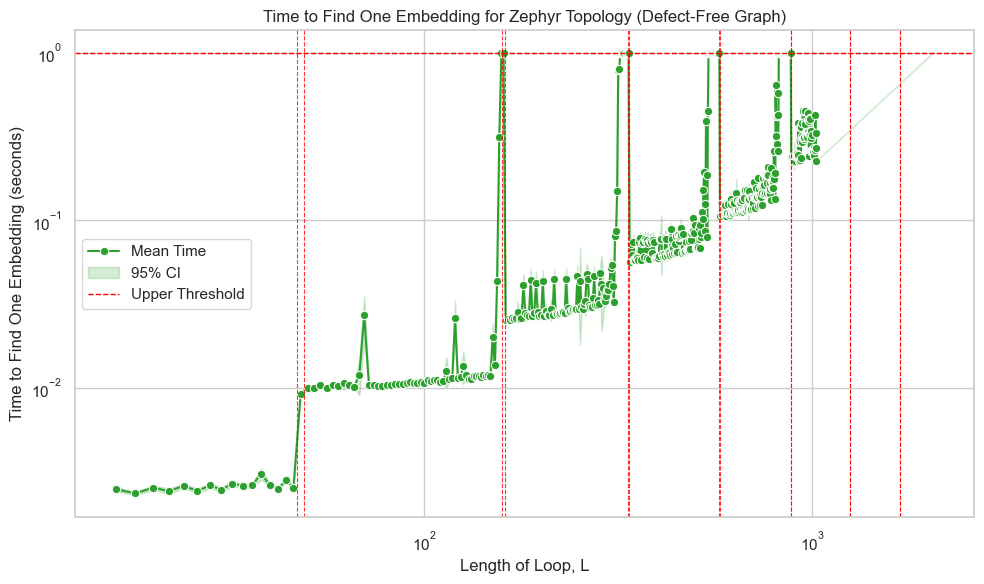

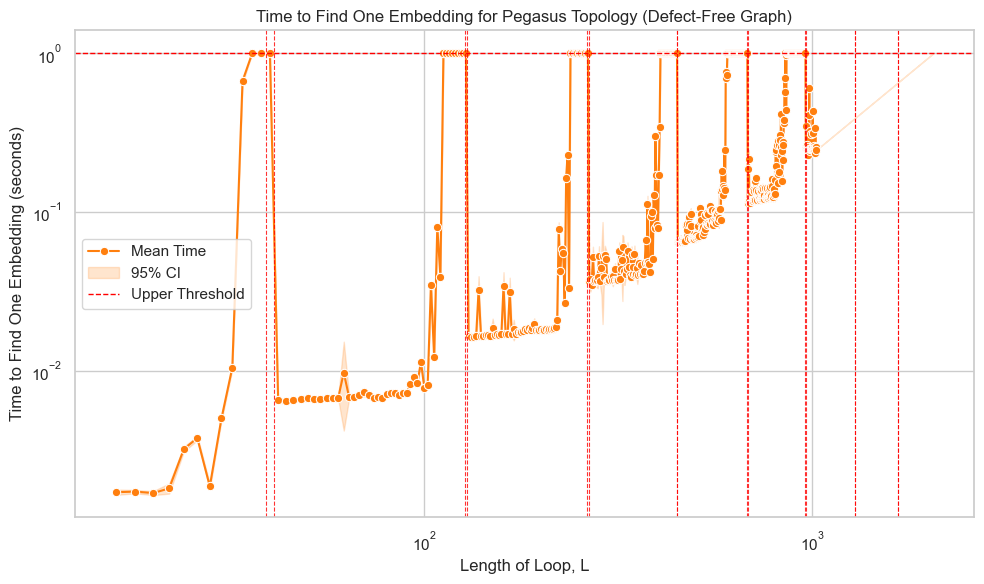

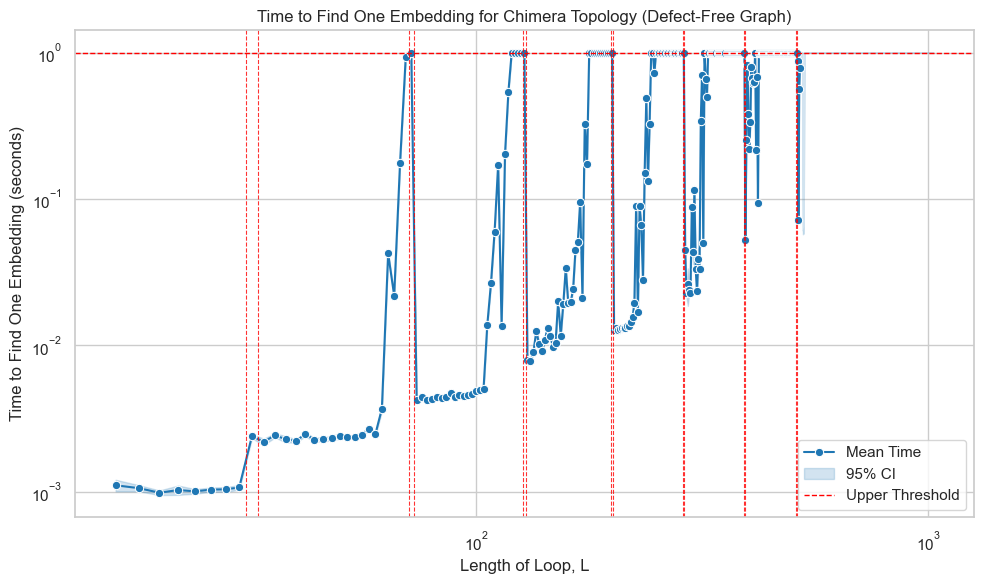

In [94]:
def plot_topology(df, topology, bounds, color, l_min, l_max, title):
    df_top = df[df['Topology'] == topology].copy()
    df_filtered = df_top[(df_top['L'] >= l_min) & (df_top['L'] <= l_max)].copy()
    ci_multiplier = 1.96
    plt.figure(figsize=(10, 6))
    
    # Plot the mean embedding time with markers
    sns.lineplot(
        data=df_filtered,
        x='L',
        y='Time_1_mean',
        color=color,
        marker='o',
        label='Mean Time'
    )
    
    # Calculate the confidence interval bounds
    ci_lower = df_top['Time_1_mean'] - ci_multiplier * df_top['Time_1_sem']
    ci_upper = df_top['Time_1_mean'] + ci_multiplier * df_top['Time_1_sem']
    
    # Plot the shaded confidence interval
    plt.fill_between(
        df_top['L'],
        ci_lower,
        ci_upper,
        color=color,
        alpha=0.2,
        label='95% CI'
    )
    
    # Add vertical lines at specified L sizes
    for L in bounds:
        plt.axvline(x=L, color='red', linestyle='--', linewidth=0.8, alpha=0.8)
    
    # Define the upper threshold line
    upper_threshold = 1
    plt.axhline(
        upper_threshold, 
        color='red', 
        linestyle='--',
        linewidth=1,
        label='Upper Threshold'
    )
    
    # Set logarithmic scales for both axes
    plt.yscale('log')
    plt.xscale('log')
    
    # Set labels and title
    plt.ylabel('Time to Find One Embedding (seconds)')
    plt.xlabel('Length of Loop, L')
    plt.title(title)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

sns.set_theme(style="whitegrid")

# ------------------- Zephyr Topology Plot -------------------
zephyr_bounds = [47, 49, 159, 161, 335, 337, 575, 577, 879, 881, 1247, 1249, 1679, 1681]
zephyr_color = (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)  # Greenish
zephyr_title = 'Time to Find One Embedding for Zephyr Topology (Defect-Free Graph)'

plot_topology(
    df=df_aggregated,
    topology='zephyr',
    bounds=zephyr_bounds,
    color=zephyr_color,
    l_min=16,
    l_max=1700,
    title=zephyr_title
)

# ------------------- Pegasus Topology Plot -------------------
pegasus_bounds = [39, 41, 127, 129, 263, 265, 447, 449, 679, 681, 959, 961, 1287, 1289, 1663, 1665]
pegasus_color = (1.0, 0.4980392156862745, 0.054901960784313725)  # Orange
pegasus_title = 'Time to Find One Embedding for Pegasus Topology (Defect-Free Graph)'

plot_topology(
    df=df_aggregated,
    topology='pegasus',
    bounds=pegasus_bounds,
    color=pegasus_color,
    l_min=16,
    l_max=1700,
    title=pegasus_title
)

# ------------------- Chimera Topology Plot -------------------
chimera_bounds = [31, 33, 71, 73, 127, 129, 199, 201, 287, 289, 391, 393, 511, 513]
chimera_color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)  # Bluish
chimera_title = 'Time to Find One Embedding for Chimera Topology (Defect-Free Graph)'

plot_topology(
    df=df_aggregated,
    topology='chimera',
    bounds=chimera_bounds,
    color=chimera_color,
    l_min=16,
    l_max=520,
    title=chimera_title
)

#### **When the loop length is comparable to the tile sizes, the timescale significantly increases! Once the loop size cross the threshold and a larger tile sizes are used, the timing becomes consistant**

### Timing Analysis for Embedding on Supremacy Lattices
The plots below display the time to find one embedding on various supremacy lattices using Pegasus. We tested all raster breadth values from the minimum visible to the maximum processor scale, along with the default (None), which employs a multi-embedding search. Each plot represents a unique lattice topology, with shape on the x-axis and time (log scale) on the y-axis.

#### **Purpose: Determine if choosing specific raster breadths improves embedding search efficiency**


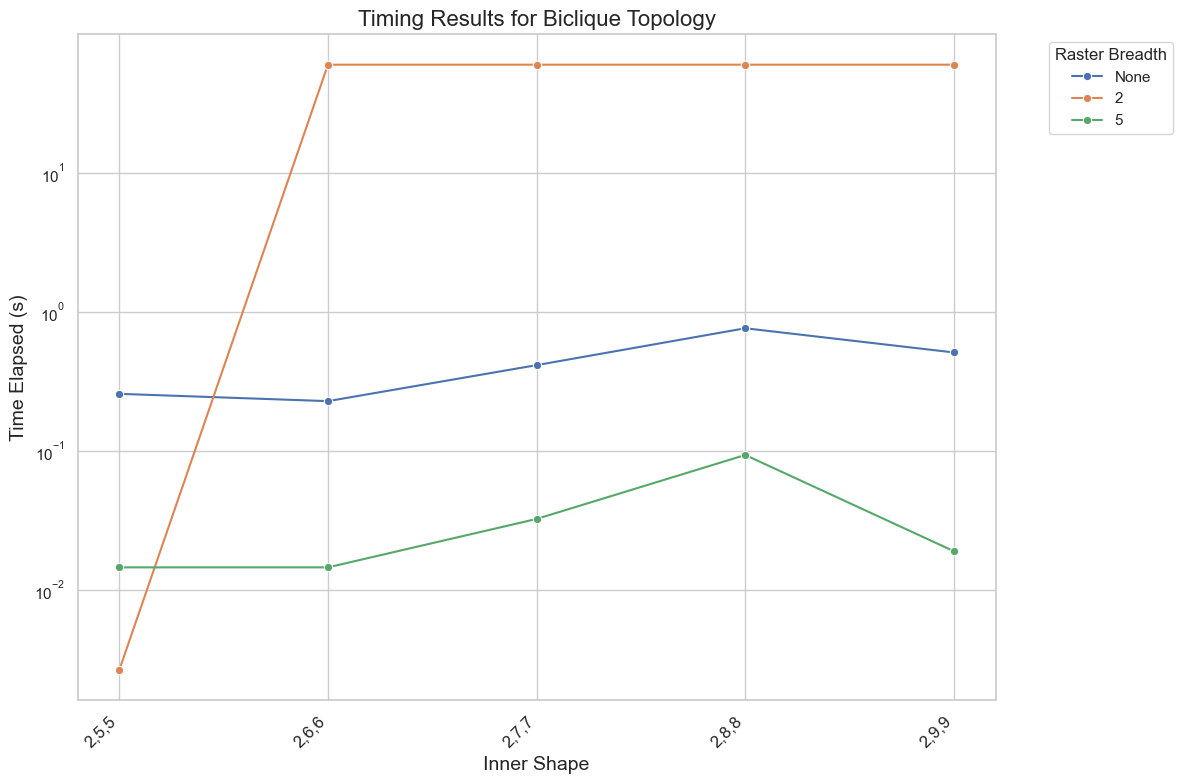

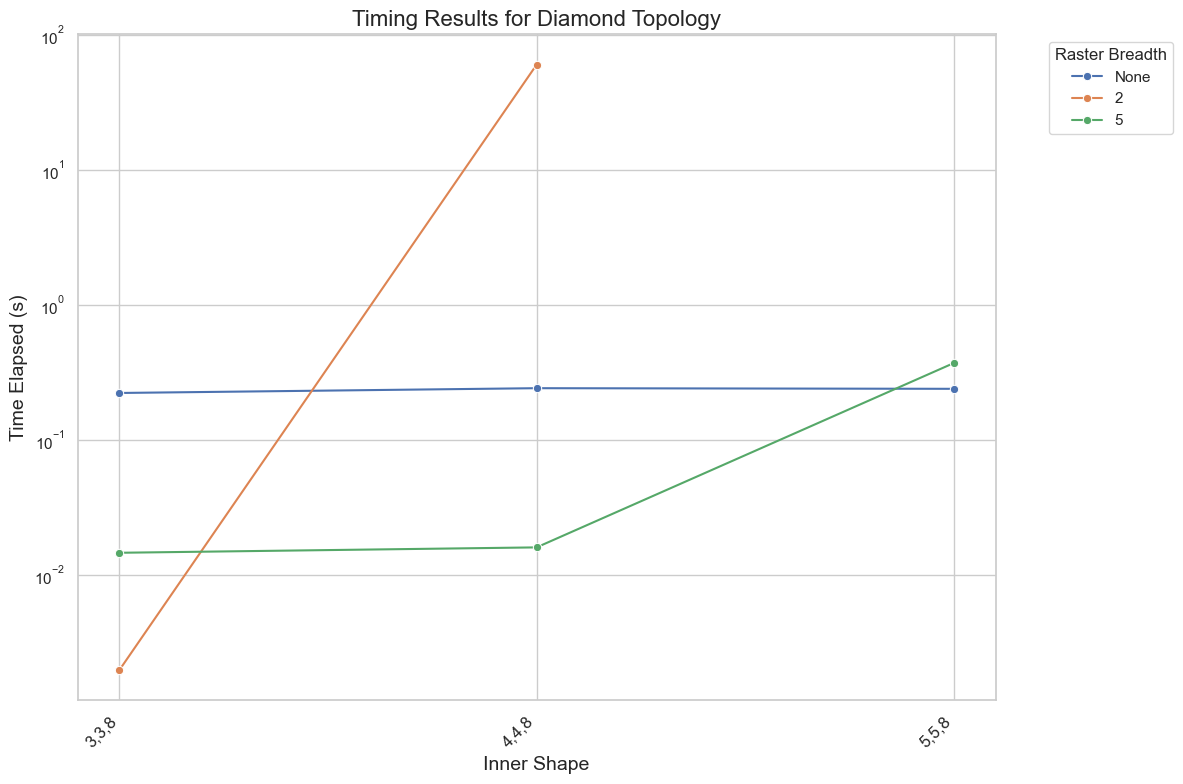

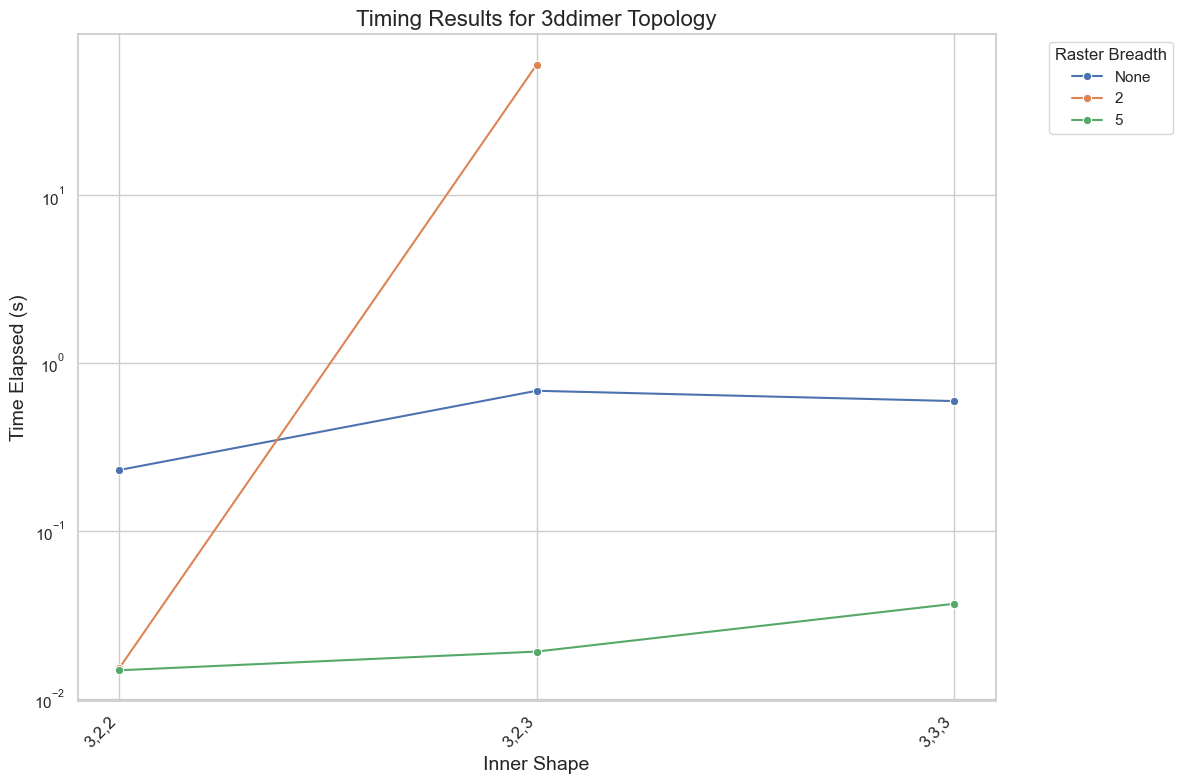

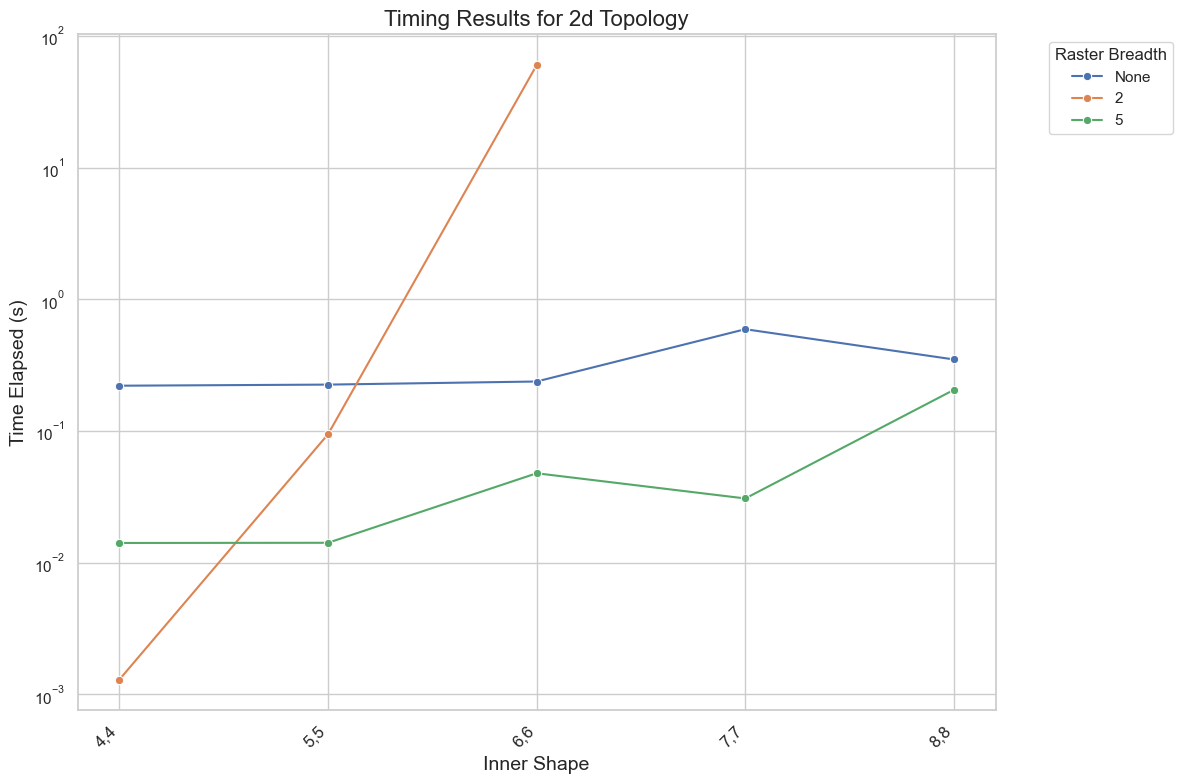

In [156]:
# Define the paths to the JSON files
folder_path = "experiment_results"
rb_file_name = "rb_timing_results.json"
none_file_name = "rb_None_results.json"
rb_file_path = os.path.join(folder_path, rb_file_name)
none_file_path = os.path.join(folder_path, none_file_name)

# Load rb_timing_results.json
with open(rb_file_path, 'r') as f:
    rb_data = json.load(f)

# Load None_results.json
with open(none_file_path, 'r') as f:
    none_data = json.load(f)

# Transform rb_data into a DataFrame
rb_records = []
for lattice_name, shapes in rb_data.items():
    for shape_entry in shapes:
        shape = shape_entry["shape"]
        shape_str = ','.join(map(str, shape))  # Convert shape list to string
        for result in shape_entry["results"]:
            rb = result["raster_breadth"]
            time = result["time_elapsed"]
            # Handle 'null' by setting to NaN or a specific value
            if time == "null":
                time = 60  # Or set to a specific value, e.g., 5
            rb_records.append({
                "lattice_name": lattice_name,
                "shape": shape_str,
                "raster_breadth": rb,
                "time_elapsed": time
            })

# Transform none_data into a DataFrame
none_records = []
for lattice_name, shapes in none_data.items():
    for shape_entry in shapes:
        shape = shape_entry["shape"]
        shape_str = ','.join(map(str, shape))  # Convert shape list to string
        time = shape_entry["time_elapsed"]
        none_records.append({
            "lattice_name": lattice_name,
            "shape": shape_str,
            "raster_breadth": 'None',
            "time_elapsed": time
        })

rb_df = pd.DataFrame(rb_records)
rb_df['raster_breadth'] = rb_df['raster_breadth'].astype(int)
rb_df['time_elapsed'] = pd.to_numeric(rb_df['time_elapsed'], errors='coerce')
none_df = pd.DataFrame(none_records)
none_df['time_elapsed'] = pd.to_numeric(none_df['time_elapsed'], errors='coerce')

mean_times = rb_df.groupby('raster_breadth')['time_elapsed'].mean()
optimal_rb = mean_times.idxmin()
lowest_mean_time = mean_times.min()
optimal_rb_df = rb_df[rb_df['raster_breadth'] == optimal_rb].copy()
optimal_rb_df.reset_index(drop=True, inplace=True)
rb_2_df = rb_df[rb_df['raster_breadth'] == 2].copy()
rb_2_df.reset_index(drop=True, inplace=True)
#rb_3_df = rb_df[rb_df['raster_breadth'] == 3].copy()
#rb_3_df.reset_index(drop=True, inplace=True)
#rb_4_df = rb_df[rb_df['raster_breadth'] == 4].copy()
#rb_4_df.reset_index(drop=True, inplace=True)
combined_df = pd.concat([none_df, rb_2_df, optimal_rb_df], ignore_index=True)

# Ensure all relevant columns are present and correctly typed
combined_df['shape'] = combined_df['shape'].astype(str)
combined_df['lattice_name'] = combined_df['lattice_name'].astype(str)
combined_df['raster_breadth'] = combined_df['raster_breadth'].astype(str)
combined_df['time_elapsed'] = pd.to_numeric(combined_df['time_elapsed'], errors='coerce')
# Get list of unique lattice names
unique_lattices = rb_df['lattice_name'].unique()

for lattice in unique_lattices:

    # Filter data for the current lattice
    lattice_df = combined_df[combined_df['lattice_name'] == lattice]
    
    # Create a new figure
    plt.figure(figsize=(12, 8))
    
    # Plot lines for each raster breadth
    sns.lineplot(
        data=lattice_df,
        x='shape',
        y='time_elapsed',
        hue='raster_breadth',
        marker='o'
    )
    # Set the y-axis to log scale if the data spans multiple orders of magnitude
    plt.yscale('log')
    
    # Set labels and title
    plt.xlabel('Inner Shape', fontsize=14)
    plt.ylabel('Time Elapsed (s)', fontsize=14)
    plt.title(f'Timing Results for {lattice.capitalize()} Topology', fontsize=16)
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=12)
    
    # Customize legend
    plt.legend(title='Raster Breadth', title_fontsize=12, fontsize=11, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Display the plot
    plt.show()





#### **It's not trivial, but for now we recommend choosing raster breadth so that the tile size is about twice the size of the source graph. This is typically close to minimum_viable_breadth+1, we provide a calculator for this.**